<a href="https://colab.research.google.com/github/WMaroney/test/blob/master/Intel_Image_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import os


# Important
When you make a copy of this notebook, in your copy, you will likely need to enable the GPU: Under 'Runtime' above, choose 'Change runtime type' > 'hardware accelerator' > GPU > Save

In [0]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Getting Data Ready

In [0]:
# Returns a list of the 6 classes
def load_labels(data_dir):
    dsets = {x: datasets.ImageFolder((data_dir))
             for x in ['train']}  
    return (dsets['train'].classes) 

In [0]:
train_data_dir = '/content/gdrive/My Drive/intel-image/seg_train'
test_data_dir = '/content/gdrive/My Drive/intel-image/seg_test'
classes = load_labels(train_data_dir)


In [0]:
# Alters the images: resizes, ToTensor transforms them into the data type the networks take, Normalizes the data
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pytorch's ImageFolder class allows us to read data in the format it's in
train_dataset = datasets.ImageFolder(root=train_data_dir,transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_dir,transform=test_transforms)

In [0]:
# Use's the datasets we just made to make DataLoaders for the networks input
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=4,
                                           pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6,
                                         shuffle=True)

In [0]:
# Un-normalizes an image
# From Joel Simon on the pytorch forums, 
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

forest   sea glacier forest street buildings glacier mountain mountain buildings glacier   sea buildings glacier glacier forest glacier street mountain mountain buildings buildings mountain forest glacier forest   sea mountain buildings buildings street mountain


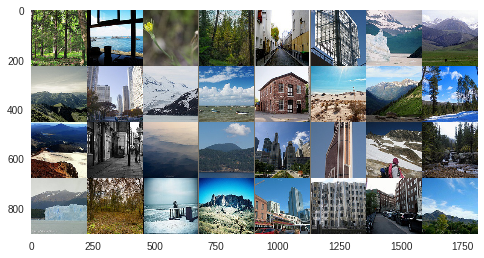

In [0]:
# Print some examples of the data
import matplotlib.pyplot as plt

def imshow(img):
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    unorm(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.rcParams["axes.grid"] = False
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

# Models
- Can look up 'torchvision models' to find more pretrained
- Run only the one model you want to work on 
- If you train a model, you must save it if you want to keep it, if your connection to colab ends it will forget the parameters.
- Reset a model just by reloading it.


## ResNet18 Model, 92.7% Overall 15 Epochs - NEED TO RUN net.eval() before testing. That's right above the accuracy cell

- May need to unfreeze more layers, not sure whats wrong yet, use VGG16 for now



In [0]:
# ResNet18
import torchvision.models as models

# Import the pretrained ResNet18 model
net = models.resnet18(pretrained='True')
net = net.cuda() #

# Loop through the network freezing layers so they don't learn
for param in net.parameters(): 
    param.requires_grad = False

# Reset the last few layers so they do learn, and change the fc layer to output 
# 6, for our six classes
net.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
net.layer4[1].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).cuda()
net.fc = nn.Linear(in_features=512, out_features=6, bias=True).cuda()

# This sets device to the GPU we are using, we use the variable several times later
device = torch.device("cuda:0")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 72865814.02it/s]


# VGG16 model, best 92% Acc - DONT need to run 'net.eval()' 


In [0]:
# VGG16
import torchvision.models as models
net = models.vgg16(pretrained="True")
net = net.cuda()

# Freeze all layers
for param in net.parameters():
    param.requires_grad = False
    
# Unfreeze layers for retraining
net.features[28] = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).cuda()
net.classifier[3] = nn.Linear(4096,4096).cuda()
net.classifier[6] = nn.Linear(4096,6).cuda()

# This sets device to the GPU we are using, we use the variable several times later
device = torch.device("cuda:0")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:07, 71179893.87it/s]


# Alexnet model, best 91%, Don't need net.eval()

In [0]:
# Alexnet
import torchvision.models as models
net = models.alexnet(pretrained="True")
net = net.cuda()

# Freeze all layers
for param in net.parameters():
    param.requires_grad = False
    
# Unfreeze layers for retraining
#net.features[8] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).cuda()
net.features[10] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).cuda()
net.classifier[1] = nn.Linear(in_features=9216, out_features=4096, bias=True).cuda()
net.classifier[4] = nn.Linear(in_features=4096, out_features=4096, bias=True).cuda()
net.classifier[6] = nn.Linear(in_features=4096, out_features=6, bias=True).cuda()

# This sets device to the GPU we are using, we use the variable several times later
device = torch.device("cuda:0")

In [0]:
# Not necessary to run
# This will print the network just implemented 
net

In [0]:
net.features[10]

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [0]:
# Not necessary to run
# If you run the 'net' cell, at the bottom you can see how I indexed the layers with these statements
# Specifically for the VGG model, look at the bottom of Cell 25, you see where it's used to unfreeze layers
# ResNet is different, but similiar
print(type(net.classifier[3]))
print(net.features[28])


<class 'torch.nn.modules.linear.Linear'>
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Training
- Watch the loss output. Overtime it should be going down overall.

In [0]:
# criterion is the loss function we are using
# optimizer is the algorithm for gradient descent
# google it lol
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [0]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.2996
[1,   200] loss: 0.7601
[1,   300] loss: 0.5551
[1,   400] loss: 0.4533
[2,   100] loss: 0.3771
[2,   200] loss: 0.3614
[2,   300] loss: 0.3407
[2,   400] loss: 0.3199
[3,   100] loss: 0.2949
[3,   200] loss: 0.3092
[3,   300] loss: 0.2897
[3,   400] loss: 0.2801
[4,   100] loss: 0.2654
[4,   200] loss: 0.2695
[4,   300] loss: 0.2696
[4,   400] loss: 0.2677
[5,   100] loss: 0.2502
[5,   200] loss: 0.2571
[5,   300] loss: 0.2521
[5,   400] loss: 0.2409
[6,   100] loss: 0.2483
[6,   200] loss: 0.2177
[6,   300] loss: 0.2342
[6,   400] loss: 0.2451
[7,   100] loss: 0.2230
[7,   200] loss: 0.2245
[7,   300] loss: 0.2134
[7,   400] loss: 0.2407
[8,   100] loss: 0.2188
[8,   200] loss: 0.2194
[8,   300] loss: 0.2090
[8,   400] loss: 0.2302
[9,   100] loss: 0.2146
[9,   200] loss: 0.2034
[9,   300] loss: 0.2014
[9,   400] loss: 0.2193
[10,   100] loss: 0.2057
[10,   200] loss: 0.1986
[10,   300] loss: 0.1987
[10,   400] loss: 0.2068
[11,   100] loss: 0.1947
[11,   200]

KeyboardInterrupt: ignored

In [0]:
net.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

# Accuracy
- Can work on getting precision and recall

In [0]:
totalCorrect = 0
total = 0
net.to(device)
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        #print(c)
        #print(labels)
        for i in range(6):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1
          

for i in range(6):
    totalCorrect += class_correct[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    total += class_total[i]
    print(class_correct[i],class_total[i])
    
print("\nOverall Accuracy = ",100*totalCorrect/total)
    

Accuracy of buildings : 89 %
390.0 437.0
Accuracy of forest : 97 %
462.0 474.0
Accuracy of glacier : 83 %
461.0 553.0
Accuracy of mountain : 78 %
411.0 525.0
Accuracy of   sea : 92 %
474.0 510.0
Accuracy of street : 89 %
446.0 501.0

Overall Accuracy =  88.13333333333334


# Accuracy 2
I just copied the above so I could add more features without messing the original code up, don't need to run this.

In [0]:
totalCorrect = 0
total = 0
tensor_list = []
net.to(device)
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    for data in test_loader: # Iterate through data and send to network
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze() 
        
        #if 0 in c:
          #print(predicted)
          #print(c)
        #print(c[i].item())
        # Counts up the correct and total for each class
        for i in range(6):
          label = labels[i]
          if c[i].item() == 0:
            #print(label)
            #print(images)
            tensor_list.append(images)
          class_correct[label] += c[i].item()
          class_total[label] += 1
          
# Adds up totals and outputs
for i in range(6):
    totalCorrect += class_correct[i]
    total += class_total[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    print(class_correct[i],class_total[i])
    
print("\nOverall Accuracy = ",100*totalCorrect/total)
    

Accuracy of buildings : 91 %
399.0 437.0
Accuracy of forest : 99 %
471.0 474.0
Accuracy of glacier : 83 %
460.0 553.0
Accuracy of mountain : 87 %
461.0 525.0
Accuracy of   sea : 98 %
500.0 510.0
Accuracy of street : 95 %
476.0 501.0

Overall Accuracy =  92.23333333333333


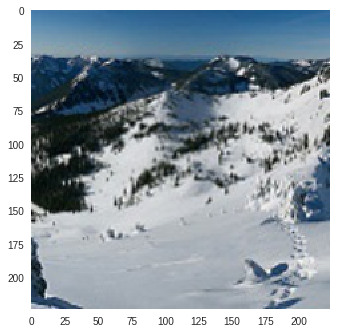

In [0]:
# More of me testing things, not needed
# Trying to collect the some of the worst predictions and display the images
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
def imshow2(img):
    unorm(img)
    npimg = img.numpy()
    plt.rcParams["axes.grid"] = False
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# show image
imshow2(torchvision.utils.make_grid(tensor_list[5][0].cpu()))

# Save/Load the model
- Prompts just to make sure, dont want to overwrite, or load a model over your trained model

In [0]:
# Save
check = input('Sure you want to SAVE?  enter "Y" to save, or anything to not save: ')
if check.upper() == 'Y':
  name = input('Model will be saved as this name: ')
  torch.save(net.state_dict(),'/content/gdrive/My Drive/'+name)
print(name,'is saved in your google drive')

Sure you want to SAVE?  enter "Y" to save, or anything to not savey
Model will be saved as this name: test_net
test_net is in your google drive


In [0]:
# Load
check = input('Sure you want to LOAD? enter "y" to load, or anything to not load')
if check.upper() == 'Y':
  name = input('Model you want to load: ')
  net.load_state_dict(torch.load('/content/gdrive/My Drive/'+name))
  net.eval()

Sure you want to LOAD? enter "y" to load, or anything to not loadIntelResNet18_100ep.tar
